In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)




In [2]:
# load train data to build model
df = pd.read_csv('data/train.csv')
df.head()

,category,rating,reviews,installs,type,price,content_rating,app_size,last_updated_encoded
0,Business,4.30000,171771,10000000,Free,0.00000,Everyone,3.20000,2936
1,Tools,4.10000,981,100000,Free,0.00000,Everyone,0.07129,439
2,Family,4.30000,109,5000,Free,0.00000,Everyone,2.70000,2731
3,Family,4.30000,21,1000,Free,0.00000,Everyone,2.50000,2941
4,Libraries_And_Demo,4.30000,332083,10000000,Free,0.00000,Everyone,6.30000,3034


In [3]:
df.columns

Index(['category', 'rating', 'reviews', 'installs', 'type', 'price',
       'content_rating', 'app_size', 'last_updated_encoded'],
      dtype='object')

# Data Exploration
* Categorical, bar charts - Amee 
* Histograms - Flora
* Scatter plots matrix of all numeric variables - Sandy
* Correlation analysis for numeric variables (heatmap)  - Sandy 


# Bar Chats for Categorical Variables 

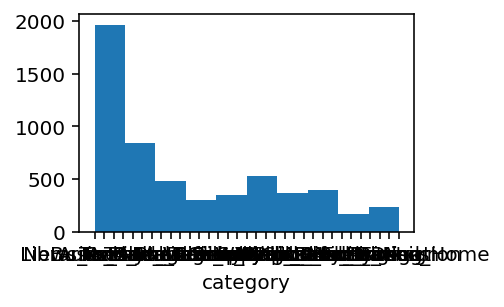

In [4]:
# Category 
fig, ax = plt.subplots(figsize=(3,2))
ax.hist(df['category'])
ax.set_xlabel("category")
plt.show()

In [10]:
# Which categories are the most popular? 
df.groupby('category').count().sort_values('reviews', ascending = False)

,rating,reviews,installs,type,price,content_rating,app_size,last_updated_encoded
category,,,,,,,,
Family,1254,1254,1254,1254,1254,1254,1254,1254
Game,660,660,660,660,660,660,660,660
Tools,486,486,486,486,486,486,486,486
Personalization,219,219,219,219,219,219,219,219
Medical,214,214,214,214,214,214,214,214
Finance,210,210,210,210,210,210,210,210
Lifestyle,204,204,204,204,204,204,204,204
Business,180,180,180,180,180,180,180,180
Productivity,180,180,180,180,180,180,180,180


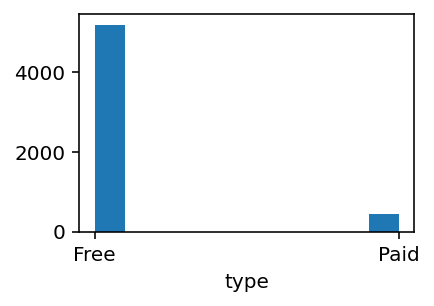

In [15]:
# Type of game (free vs paid)
fig, ax = plt.subplots(figsize=(3,2))
ax.hist(df['type'])
ax.set_xlabel('type')
plt.show()

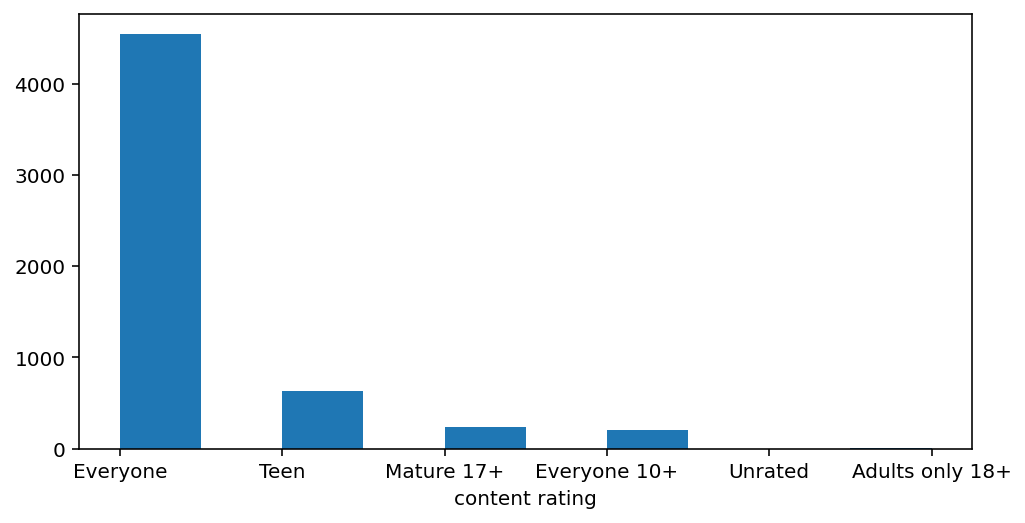

In [21]:
# Content rating 
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(df['content_rating'])
ax.set_xlabel('Content Rating')
plt.show()

# Initial model fit with all variables

In [28]:
# regress rating against all other variables
ystr = 'rating'
xstr = '+'.join([col for col in df.columns if col != ystr])

# build initial ols model 
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     8.362
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           1.09e-49
Time:                        20:36:35   Log-Likelihood:                -4525.3
No. Observations:                5623   AIC:                             9139.
Df Residuals:                    5579   BIC:                             9431.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

# ANOVA

In [40]:
partial = sa.anova_lm(model, type=2)
seq = sa.anova_lm(model, type=1)

print('~~~~~~~ Partial ANOVA ~~~~~~~')
print(partial)

print('\n~~~~~~~ Sequential ANOVA ~~~~~~~')
print(seq)

~~~~~~~ Partial ANOVA ~~~~~~~
                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.20283 0.00000
type                    1.00000    1.48364  1.48364   5.02760 0.02499
content_rating          5.00000    1.65630  0.33126   1.12254 0.34589
reviews                 1.00000    6.61363  6.61363  22.41152 0.00000
installs                1.00000    0.23373  0.23373   0.79205 0.37352
price                   1.00000    0.73689  0.73689   2.49708 0.11411
app_size                1.00000    1.42234  1.42234   4.81986 0.02817
last_updated_encoded    1.00000   35.39224 35.39224 119.93326 0.00000
Residual             5579.00000 1646.35997  0.29510       nan     nan

~~~~~~~ Sequential ANOVA ~~~~~~~
                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.20283 0.00000
type                    1.00000    1.48364  1.48364   5.02760 0.02499
content_rating          5.

# Influential Points

### Cook's Distance

In [33]:
# Lots of influential points 
infl = model.get_influence()
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d
atyp_cook = np.abs(reg_cook) >= 4/len(df)
print(df.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([   7,   46,   49,   66,  170,  198,  202,  209,  226,  279,
            ...
            5443, 5457, 5477, 5503, 5516, 5539, 5541, 5565, 5573, 5594],
           dtype='int64', length=246) 7      0.00080
46     0.00175
49     0.00076
66     0.00142
170    0.00110
         ...  
5539   0.00309
5541   0.00077
5565   0.00080
5573   0.00093
5594   0.00227
Name: cooks_d, Length: 246, dtype: float64


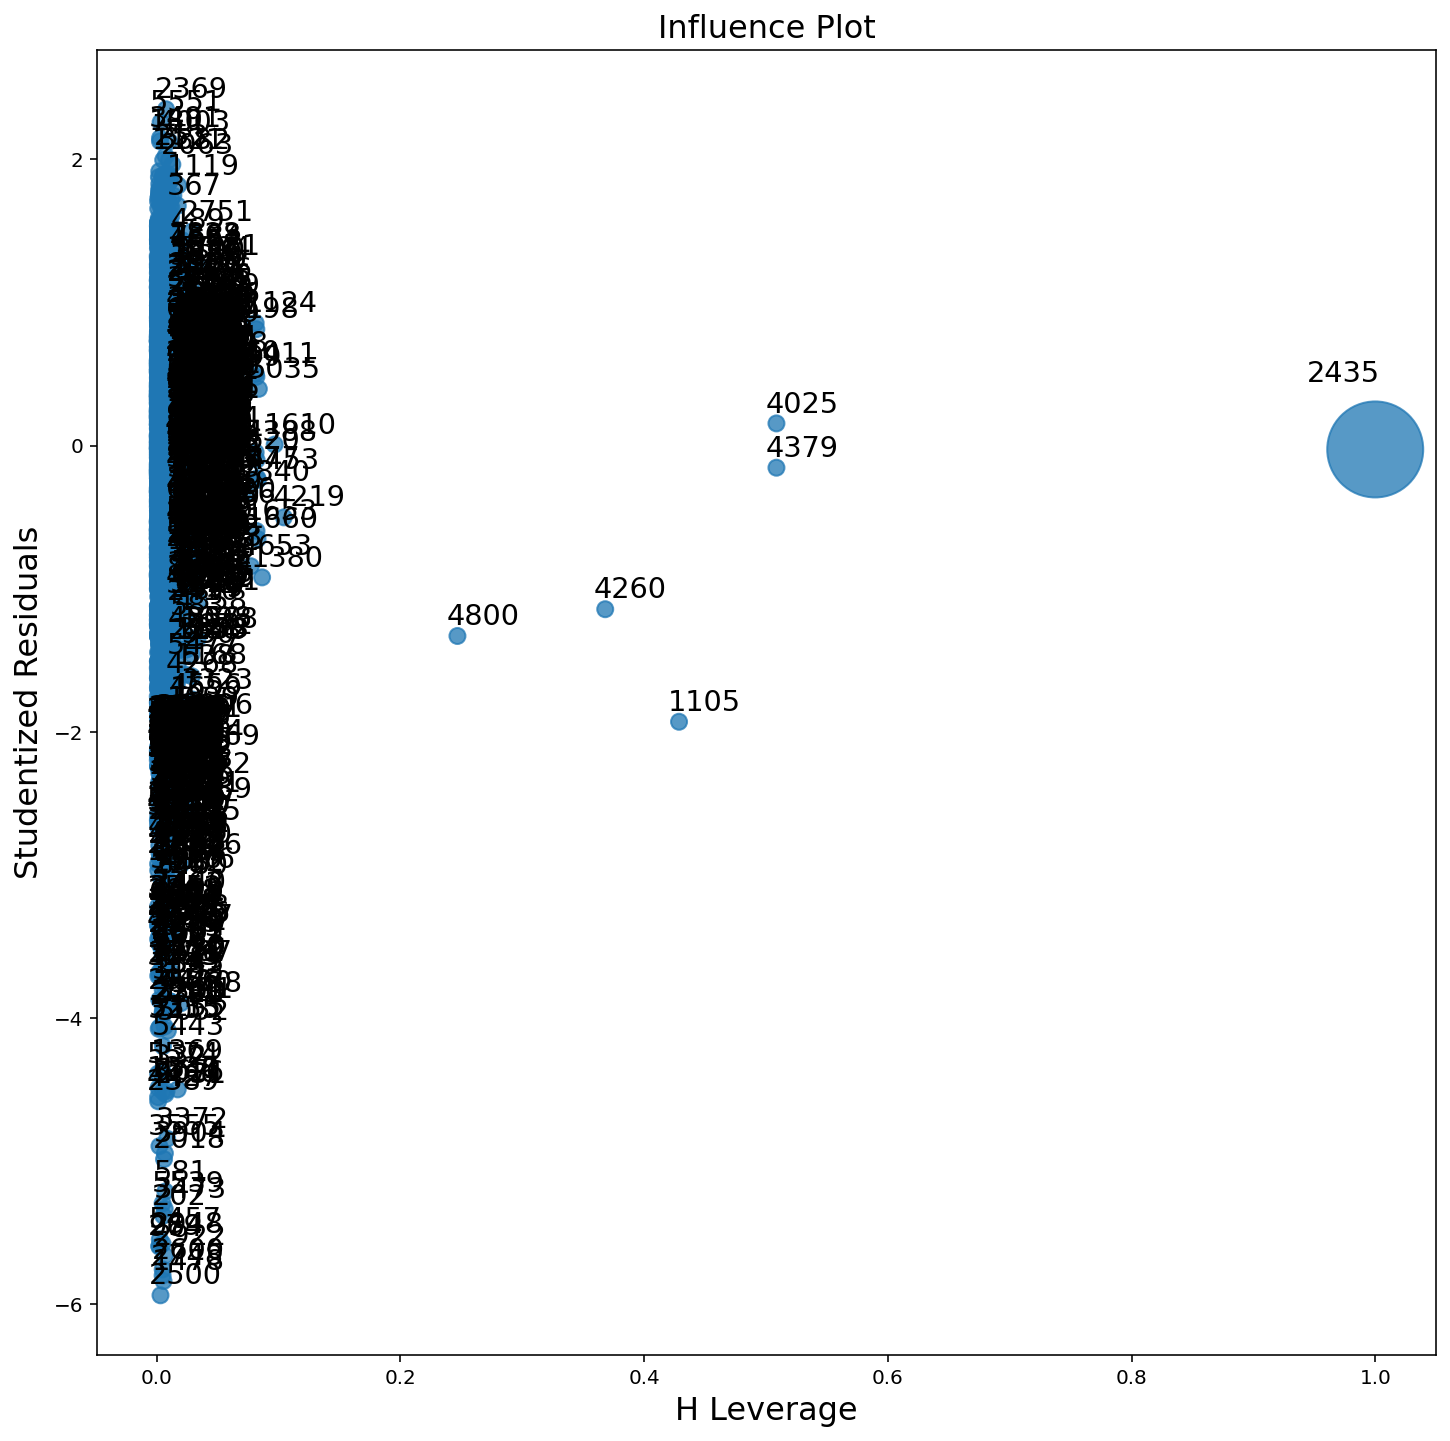

In [34]:
#graphical representation of the influences()
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 

In [35]:
# What is point 2435? Not sure what is so strange about this point.....
df.iloc[2435]

category                  Tools
rating                  4.10000
reviews                    1186
installs                  50000
type                       Free
price                   0.00000
content_rating          Unrated
app_size                6.40000
last_updated_encoded        787
Name: 2435, dtype: object

In [37]:
df.describe()

,rating,reviews,installs,price,app_size,last_updated_encoded
count,5623.00000,5623.00000,5623.00000,5623.00000,5623.00000,5623.00000
mean,4.15947,146913.36920,4395688.27957,1.23648,21.94416,2841.94647
std,0.55832,1088806.85430,27287095.98483,18.92014,22.89808,418.18047
min,1.00000,1.00000,1.00000,0.00000,0.00830,394.00000
25%,3.90000,85.00000,10000.00000,0.00000,4.95000,2726.00000
50%,4.30000,1545.00000,100000.00000,0.00000,13.00000,3036.00000
75%,4.50000,26535.00000,1000000.00000,0.00000,31.00000,3115.00000
max,5.00000,44891723.00000,1000000000.00000,400.00000,100.00000,3141.00000


### Externally Studentized Residuals

In [55]:
#threshold externally studentized residuals --> what is shown on the y axis above 
import scipy
n=len(df)
p= 44
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)

#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud  # identify all externally studentized residuals over the threshold 

#which ones?
print(df.index[atyp_stud],reg_studs[atyp_stud])


Int64Index([  46,   49,   51,   66,  141,  147,  170,  176,  180,  202,
            ...
            5457, 5470, 5503, 5516, 5528, 5539, 5551, 5573, 5574, 5594],
           dtype='int64', length=285) [-3.68151 -2.07592 -2.04084 -3.56081 -2.12811 -2.11337 -2.86226 -2.18236
  2.12758 -5.38456 -3.5232  -3.06306  2.02397 -5.59504 -4.40477 -3.31867
 -2.2779  -3.22186 -2.63146 -2.02569 -3.38141 -4.51351 -3.04362 -2.04765
 -2.60069 -2.17545 -4.50117 -2.32857 -2.62057 -2.05159 -5.21496 -2.28242
 -3.25257 -2.14098 -2.0774  -2.15882 -1.99323 -2.68142 -3.38118 -2.43123
 -2.15514 -2.23932 -2.04344 -2.22629 -2.55318 -2.49986 -1.99428 -3.88406
 -5.60087 -2.04378 -2.06239 -2.92291 -2.73344 -3.66387 -2.61465  1.99633
 -2.16796 -3.42744 -2.71893 -4.49133 -1.99691 -2.60768 -4.36938 -2.94897
 -3.9394  -2.19186 -3.38039 -2.97056 -3.19352 -2.26229 -3.49724 -5.84131
 -3.89927 -2.07756 -2.66169 -2.29209 -2.37021 -2.11422 -3.05294 -2.26874
 -3.75427 -2.45794 -3.26542 -2.33777 -3.68295 -3.3033  -2.05374 -3.7043

## Final List of Influential Points

In [59]:
# Which points are considered influential points in both Externally Studentized Residuals and Cooks?

externally_studentized = set(df.index[atyp_stud])
cooks = set(df.index[atyp_cook])

influential_points = externally_studentized.intersection(cooks)

len(influential_points)

infl_points_list = list(influential_points)


In [64]:
df2= df.drop(infl_points_list)  
model2 = smf.ols(f'{ystr}~{xstr}', data=df2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     10.81
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           9.12e-69
Time:                        08:49:27   Log-Likelihood:                -3296.8
No. Observations:                5453   AIC:                             6682.
Df Residuals:                    5409   BIC:                             6972.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           4.0983      0.327     12.520      0.000       3.457       4.740
category[T.Auto_And_Vehicles]      -0.1189      0.091     -1.302      0.193      -0.298       0.060
category[T.Beauty]                 -0.0889      0.106     -0.837      0.402      -0.297       0.119
category[T.Books_And_Reference]     0.0190      0.077      0.245      0.806      -0.133       0.171
category[T.Business]               -0.1875      0.073     -2.555      0.011      -0.331      -0.044
category[T.Comics]                 -0.1554      0.100     -1.554      0.120      -0.351       0.041
category[T.Communication]          -0.2191      0.075     -2.926      0.003      -0.366      -0.072
category[T.Dating]                 -0.3314      0.088     -3.788      0.000      -0.503      -0.160
category[T.Education]               0.0074      0.086      0.085      0.932      -0.162       0.177
category[T.Entertainment]          -0.2186      0.092     -2.368      0.018      -0.399      -0.038
category[T.Events]                  0.1196      0.099      1.205      0.228      -0.075       0.314
category[T.Family]                 -0.1732      0.066     -2.607      0.009      -0.303      -0.043
category[T.Finance]                -0.1988      0.072     -2.749      0.006      -0.341      -0.057
category[T.Food_And_Drink]         -0.2140      0.088     -2.431      0.015      -0.387      -0.041
category[T.Game]                   -0.1308      0.068     -1.914      0.056      -0.265       0.003
category[T.Health_And_Fitness]      0.0071      0.075      0.095      0.924      -0.140       0.155
category[T.House_And_Home]         -0.1975      0.095     -2.077      0.038      -0.384      -0.011
category[T.Libraries_And_Demo]     -0.0729      0.092     -0.793      0.428      -0.253       0.107
category[T.Lifestyle]              -0.1689      0.072     -2.330      0.020      -0.311      -0.027
category[T.Maps_And_Navigation]    -0.2980      0.082     -3.635      0.000      -0.459      -0.137
category[T.Medical]                -0.0628      0.072     -0.869      0.385      -0.204       0.079
category[T.News_And_Magazines]     -0.0933      0.077     -1.209      0.227      -0.245       0.058
category[T.Parenting]               0.0020      0.099      0.020      0.984      -0.191       0.195
category[T.Personalization]        -0.0121      0.072     -0.168      0.867      -0.153       0.129
category[T.Photography]            -0.1541      0.074     -2.079      0.038      -0.299      -0.009
category[T.Productivity]           -0.1435      0.073     -1.957      0.050      -0.287       0.000
category[T.Shopping]               -0.1313      0.077     -1.702      0.089      -0.282       0.020
category[T.Social]                 -0.0751      0.078     -0.968      0.333      -0

# Residual Variance

## Residuals Vs Fitted Values Plot

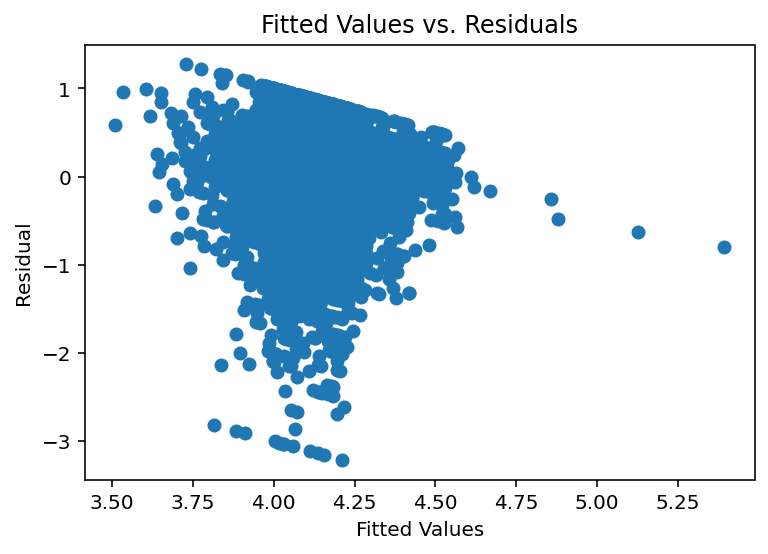

In [62]:
# Original model

p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

plt.show()

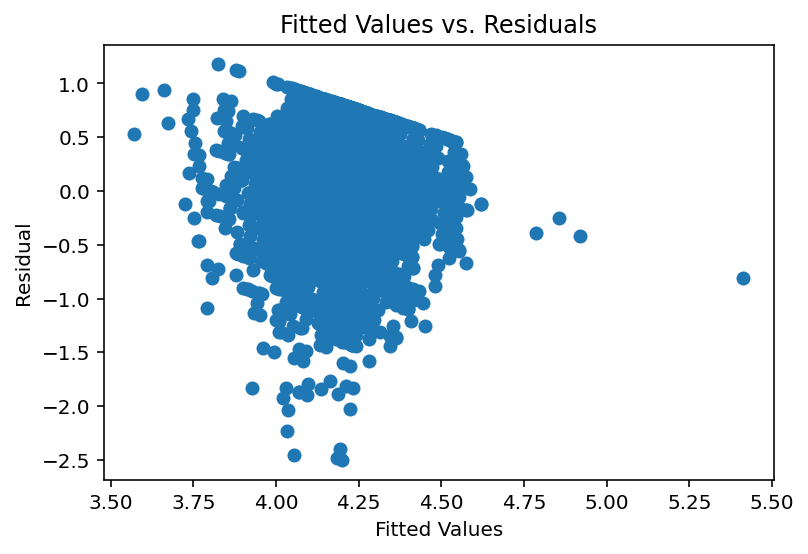

In [61]:
# Model without influential points 

p2 = model2.fittedvalues
res2 = model2.resid
plt.scatter(p2,res2)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

plt.show()

Text(0.5, 1.0, 'Fitted Values vs. Residuals after log transformation on y')

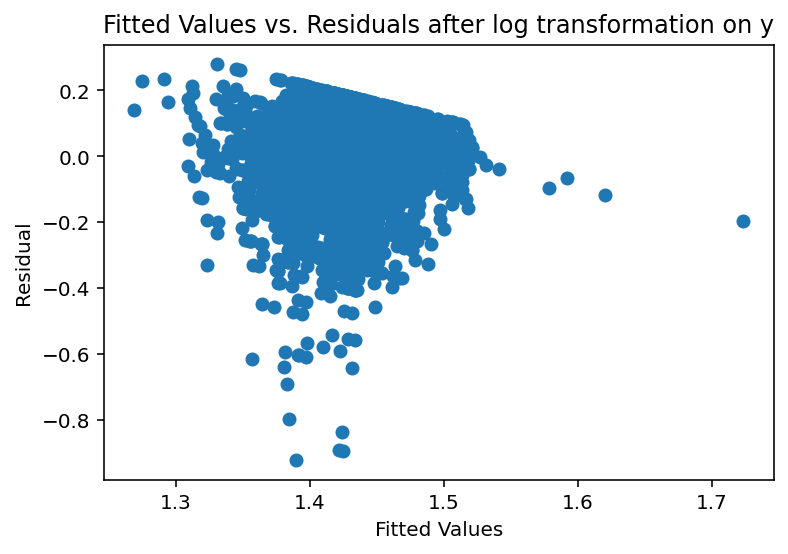

In [72]:
# Try a log transformation on y --> Didn't improve nuch 

df2['log_rating']=np.log(df2['rating'])

model3 = smf.ols(f'log_rating~{xstr}', data=df2).fit()

p3 = model3.fittedvalues
res3 = model3.resid
plt.scatter(p3,res3)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals after log transformation on y")

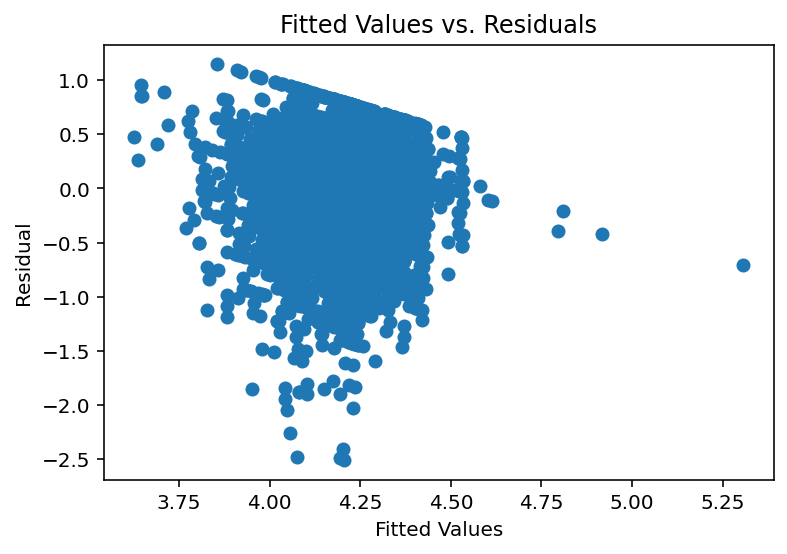

In [71]:
# Model based on Sandy's work: 
model5 = smf.ols('rating~category+reviews+last_updated_encoded' , data=df2).fit()

p5 = model5.fittedvalues
res5 = model5.resid
plt.scatter(p5,res5)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

plt.show()

# Plot shows slightly improved variance 

## BP Test
Since the p-value is less than 0.05, we reject the null that the variance of error is constant in favor of the alternate hypothesis, which states that variace of error changes with predictors. Thus, there is significant heteroskedasticity in both the full model without influential points and in the model with only 3 predictors. 

In [67]:
#Breusch-Pagan for Heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model2.resid, model2.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))


{'LM Statistic': 246.58554525404622, 'LM-Test p-value': 2.2508840998165504e-30}


In [73]:
bp_test = het_breuschpagan(model5.resid, model5.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 193.66033915938317, 'LM-Test p-value': 3.0209817702247075e-24}


# Normality 

## QQ Plot (Full model)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

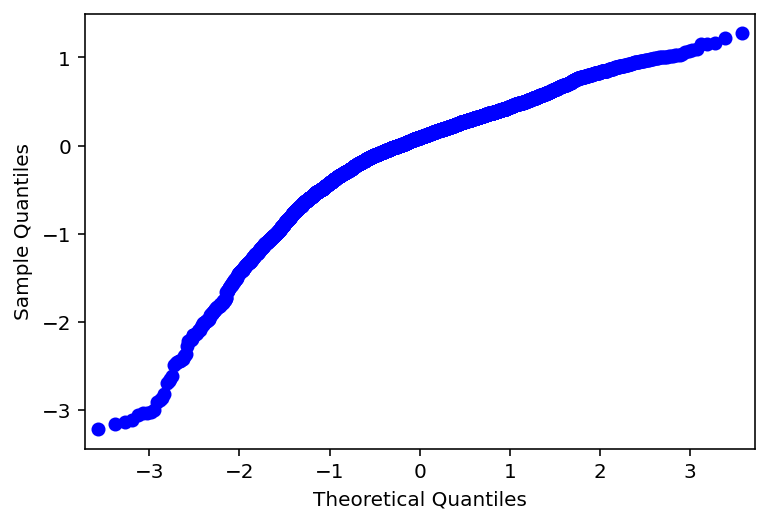

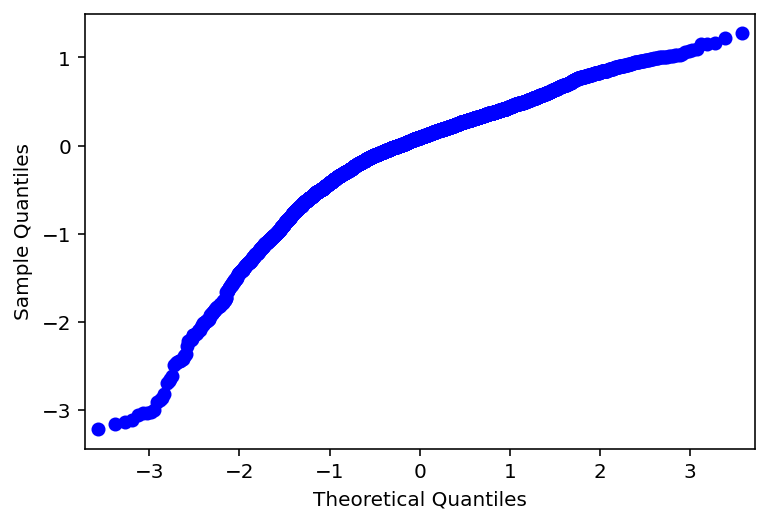

In [27]:
# Original model

sm.qqplot(model.resid)

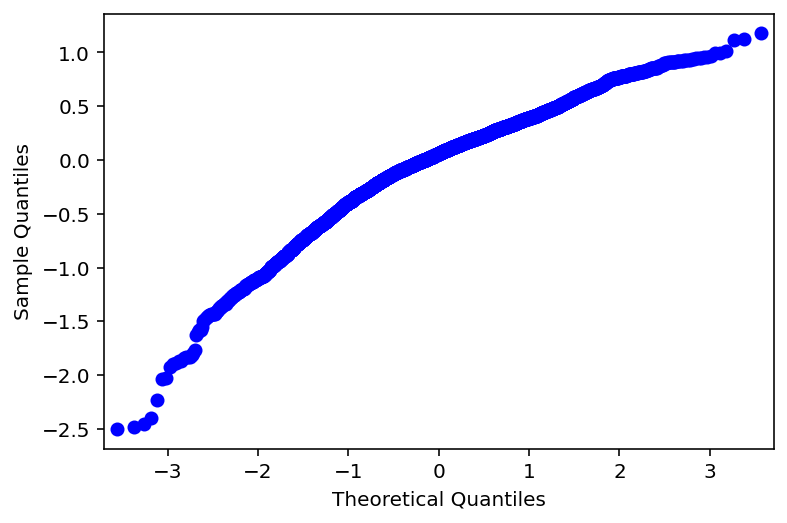

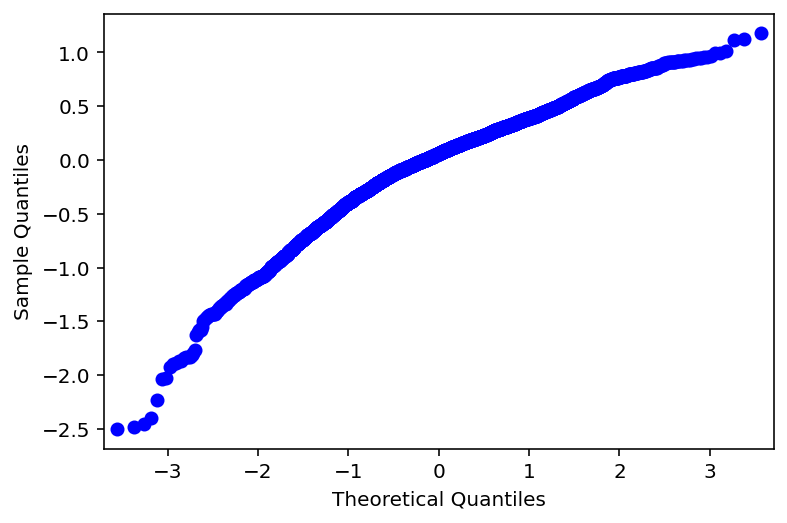

In [63]:
# Model without influential points 

sm.qqplot(model2.resid)

## JB Test 
### Original Model
The JB value for the original full model is 6665.484 with a p-value of zero. With a JB test, H0 states that the residuals are approximately normal and H1 states that residuals are not close to normal. Since our p-value for the JB stat is 0.000, we reject the null in favor of the alternate, stating that residuals are not close to normal

### Model without influential points 
The JB value for the model without influential points has a lower JB value of 1525.458. However, the p-value is still zero, meaning the residuals are not close to being normally distributed. However, given that the sample size of 5453 > 30p = 30 * 44 = 132, CLT ensures that the normality assumption is taken care of